# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from bs4 import BeautifulSoup

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,auc,roc_curve,classification_report,precision_score,recall_score,f1_score, hamming_loss

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from prettytable import PrettyTable

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:\Study_materials\Applied_AI\Assignments\database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 limit 100000""", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)

Number of data points in our data (100000, 10)


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [8]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [3] Preprocessing

In [9]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

10
I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!


In [10]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'those', 'doesn', 'wouldn', "mightn't", 'same', "didn't", 'isn', 'as', 'when', 'both', 'but', 'than', 'hadn', "mustn't", 'such', 'were', 'then', 'what', 'am', 'of', 'doing', "hasn't", 'too', 'whom', "hadn't", 'up', 'our', "isn't", "she's", 'through', 'which', 'hasn', 'who', 'only', 'while', 'so', 'yourselves', 'before', 'weren', 'won', 'it', 'or', 'hers', 'mustn', 'have', 'itself', 'no', 'over', 'during', 'just', "wouldn't", 'will', 'more', 'a', 'about', 'from', 'ain', 'into', 'haven', 'has', 'you', "you'll", "you've", 'off', 'how', 'any', 'these', 'if', 'below', 'with', 'why', 'an', 'wasn', 'mightn', "that'll", 'yourself', 'was', 'very', 'himself', 'now', 'should', 'being', 'few', "you'd", "should've", 'again', 'in', 'd', "don't", 'there', 'ma', 'be', 'didn', 'them', 'me', 'that', 'aren', 'out', 'had', "aren't", 're', 'down', 'she', 'their', 'under', 'theirs', 'did', 'having', 'further', 'myself', 'for', 'are', 'where', "couldn't", 'nor', 'against', 'other', 'until', 'o', 'each', 'y'

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.

final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [02:28<00:00, 589.18it/s]


In [12]:
final = final.sort_values('Time',axis = 0,ascending = True, inplace = False, kind = 'quicksort', na_position='last')

In [13]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [14]:
X  = final['CleanedText']

## Top 2000 words

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(ngram_range = (1,1) , max_features = 2000)
tfidf_X = tfidf_vec.fit_transform (X)

In [17]:
top_2000 = tfidf_vec.get_feature_names()

## Co-occurance Matrix

In [18]:
n_neighbor = 5
occ_matrix_2000 = np.zeros((2000,2000))
for row in tqdm(X.values):
    words_in_row = row.split()
    for index,word in enumerate(words_in_row):
        if word in top_2000:
            for j in range(max(index-n_neighbor,0),min(index+n_neighbor,len(words_in_row)-1) + 1):
                if words_in_row[j] in top_2000:
                    occ_matrix_2000[top_2000.index(word),top_2000.index(words_in_row[j])] += 1
                else:
                    pass
        else:
            pass

100%|████████████████████████████████████████████████████████████████████████████| 87773/87773 [36:25<00:00, 40.15it/s]


## Truncated SVD

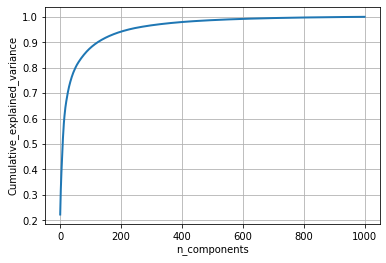

In [19]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 1000)
svd_2000 = svd.fit_transform(occ_matrix_2000)

percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)
plt.figure(figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [20]:
svd = TruncatedSVD(n_components = 150)
svd_2000 = svd.fit_transform(occ_matrix_2000)

## K-Means

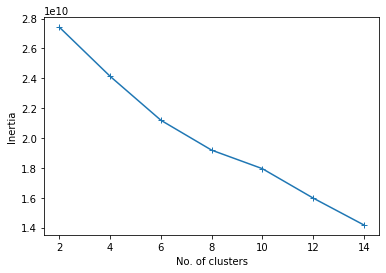

In [21]:
clusters = [2,4,6,8,10,12,14]
from sklearn.cluster import KMeans
dic = {}
for i in clusters:
    clus = KMeans(n_clusters = i)
    clus.fit(svd_2000)
    dic[i] = clus.inertia_
plt.plot(list(dic.keys()), list(dic.values()),'-+')
plt.xlabel("No. of clusters")
plt.ylabel("Inertia")
plt.show()

In [22]:
optimal_k = KMeans(n_clusters = 8)
p = optimal_k.fit(svd_2000)

In [26]:
X1 = X.values

In [27]:
# Getting all the reviews in different clusters
cluster1, cluster2, cluster3, cluster4, cluster5, cluster6, cluster7, cluster8 = [], [], [], [], [], [], [], []

for i in range(p.labels_.shape[0]):
    if p.labels_[i] == 0:
        cluster1.append(X1[i])
    elif p.labels_[i] == 1:
        cluster2.append(X1[i])
    elif p.labels_[i] == 2:
        cluster3.append(X1[i])
    elif p.labels_[i] == 3:
        cluster4.append(X1[i])
    elif p.labels_[i] == 4:
        cluster5.append(X1[i])
    elif p.labels_[i] == 5:
        cluster6.append(X1[i])
    elif p.labels_[i] == 6:
        cluster7.append(X1[i])
    else :
        cluster8.append(X1[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))

No. of reviews in Cluster-1 :  1946

No. of reviews in Cluster-2 :  48

No. of reviews in Cluster-3 :  1

No. of reviews in Cluster-4 :  1

No. of reviews in Cluster-5 :  1

No. of reviews in Cluster-6 :  1

No. of reviews in Cluster-7 :  1

No. of reviews in Cluster-8 :  1


## Word-Cloud of clusters obtained in the above section

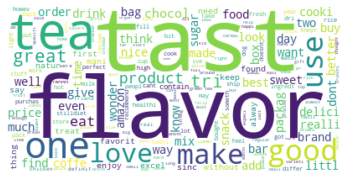

In [28]:
#Wordcloud for cluster 1 

from wordcloud import WordCloud

data=''
for i in cluster1:
    data+=str(i) 
wordcloud1 = WordCloud(background_color="white").generate(data)

# Displaying the image: 
plt.imshow(wordcloud1, interpolation='bilinear') 
plt.axis("off") 
plt.show()

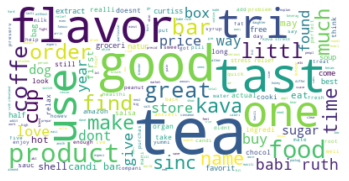

In [29]:
#Wordcloud for cluster 2 

data=''
for i in cluster2:
    data+=str(i) 
wordcloud2 = WordCloud(background_color="white").generate(data)

# Displaying the image: 
plt.imshow(wordcloud2, interpolation='bilinear') 
plt.axis("off") 
plt.show()

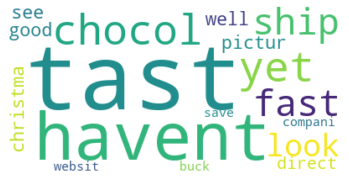

In [30]:
#Wordcloud for cluster 3 

data=''
for i in cluster3:
    data+=str(i) 
wordcloud3 = WordCloud(background_color="white").generate(data)

# Displaying the image: 
plt.imshow(wordcloud3, interpolation='bilinear') 
plt.axis("off") 
plt.show()

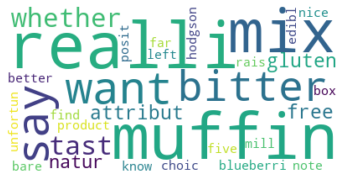

In [31]:
#Wordcloud for cluster 4 

data=''
for i in cluster4:
    data+=str(i) 
wordcloud4 = WordCloud(background_color="white").generate(data)

# Displaying the image: 
plt.imshow(wordcloud4, interpolation='bilinear') 
plt.axis("off") 
plt.show()

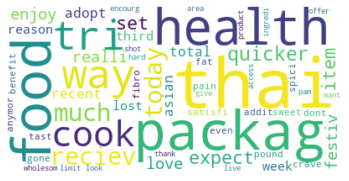

In [32]:
#Wordcloud for cluster 5 

data=''
for i in cluster5:
    data+=str(i) 
wordcloud5 = WordCloud(background_color="white").generate(data)

# Displaying the image: 
plt.imshow(wordcloud5, interpolation='bilinear') 
plt.axis("off") 
plt.show()

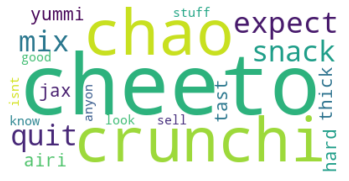

In [33]:
#Wordcloud for cluster 6 

data=''
for i in cluster6:
    data+=str(i) 
wordcloud6 = WordCloud(background_color="white").generate(data)

# Displaying the image: 
plt.imshow(wordcloud6, interpolation='bilinear') 
plt.axis("off") 
plt.show()

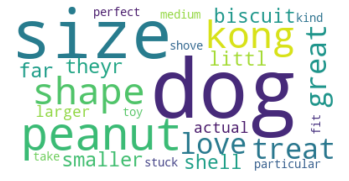

In [34]:
#Wordcloud for cluster 7 

data=''
for i in cluster7:
    data+=str(i) 
wordcloud7 = WordCloud(background_color="white").generate(data)

# Displaying the image: 
plt.imshow(wordcloud7, interpolation='bilinear') 
plt.axis("off") 
plt.show()

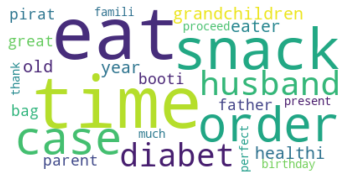

In [35]:
#Wordcloud for cluster 8 

data=''
for i in cluster8:
    data+=str(i) 
wordcloud8 = WordCloud(background_color="white").generate(data)

# Displaying the image: 
plt.imshow(wordcloud8, interpolation='bilinear') 
plt.axis("off") 
plt.show()

## 10 similar words [cosine similarity]

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
def similar_ten_words(word):
    similarity = cosine_similarity(occ_matrix_2000)
    word_vect = similarity[top_2000.index(word)]
    print("Similar Word to",word)
    index = word_vect.argsort()[::-1][1:11]
    for j in range(len(index)):
        print((j+1),"Word",top_2000[index[j]] ,"is similar to",word,"\n")

In [38]:
similar_ten_words(top_2000[6])

Similar Word to across
1 Word came is similar to across 

2 Word come is similar to across 

3 Word ran is similar to across 

4 Word tri is similar to across 

5 Word countri is similar to across 

6 Word ive is similar to across 

7 Word one is similar to across 

8 Word store is similar to across 

9 Word amazon is similar to across 

10 Word product is similar to across 



## Conclusions

1. We have taken top 2000 features based on idf values.
2. Constructed a Co-occurance Matrix with help of these 2000 features
3. Then applied Truncated SVD on co-occurance matrix with optimal no. of components.
4. Kmeans on truncated SVD to analyse the clusters.
5. Plotted the Word Cloud having cluster=8 to analyse what type of words it contain.
6. Optimal no. of component = 150 where 150 components can explain almost 95% of variance . So, I picked only 150 components instead of total 1000 components using elbow method 2) Optimal cluster = 8.